# Tutorial

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import hucira as hc

import warnings
from tqdm import TqdmWarning

warnings.simplefilter("ignore", TqdmWarning)

import time
start = time.time()

# The Human Cytokine Dictionary

The Human Cytokine Dictionary (hcd) can be accessed through this module. Your query data should be a transcriptomic data object in AnnData's .h5ad format with gene symbols in .var axis and metadata describing immune celltypes and experimental conditions of samples. Using the Human Cytokine Dictionary as reference, you can "look up" cytokine responses of the disease states in your own dataset.

# 1. Load input data

The two main input files for this tool are:
1. the Human Cytokine Dictionary 
2. your transcriptome data object

Explore their metadata annotation for cell types and disease condition.

In [2]:
#### Load the human cytokine dictionary

df_hcd_all = hc.load_human_cytokine_dict()

print(f"All celltypes in dictionary:\n  {df_hcd_all.celltype.unique()}")
print("\n")
print(f"All cytokines in dictionary:\n  {df_hcd_all.cytokine.unique()}")

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/human_cytokine_dict.csv
All celltypes in dictionary:
  ['Intermediate_B_cell' 'NKT' 'CD8_Memory_T_cell' 'NK_CD56low' 'CD16_Mono'
 'NK_CD56hi' 'CD8_Naive_T_cell' 'pDC' 'ILC' 'MAIT' 'Naive_B_cell'
 'CD4_Naive_T_cell' 'Treg' 'Plasmablast' 'Granulocyte' 'B_cell'
 'CD4_T_cell' 'HSPC' 'CD8_T_cell' 'CD14_Mono' 'cDC' 'CD4_Memory_T_cell'
 'NK' 'Mono']


All cytokines in dictionary:
  ['4-1BBL' 'ADSF' 'APRIL' 'BAFF' 'C3a' 'C5a' 'CD27L' 'CD30L' 'CD40L' 'CT-1'
 'Decorin' 'EGF' 'EPO' 'FGF-beta' 'FLT3L' 'FasL' 'G-CSF' 'GDNF' 'GITRL'
 'GM-CSF' 'HGF' 'IFN-alpha1' 'IFN-beta' 'IFN-epsilon' 'IFN-gamma'
 'IFN-lambda1' 'IFN-lambda2' 'IFN-lambda3' 'IFN-omega' 'IGF-1'
 'IL-1-alpha' 'IL-1-beta' 'IL-10' 'IL-11' 'IL-12' 'IL-13' 'IL-15' 'IL-16'
 'IL-17A' 'IL-17B' 'IL-17C' 'IL-17D' 'IL-17E' 'IL-17F' 'IL-18' 'IL-19'
 'IL-1Ra' 'IL-2' 'IL-20' 'IL-21' 'IL-22' 'IL-23' 'IL-24' 'IL-26' 'IL-27'
 'IL-3' 'IL-31' 'IL-32-beta' 'IL-33' 'IL-34' 'IL-3

In [3]:
#### Load the query adata object

adata = hc.load_Lupus_data()
adata

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/lupus.h5ad


AnnData object with n_obs × n_vars = 1263676 × 30172
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

In [4]:
#### For easy workflow:
# Enter celltype column name and condition column name

your_celltype_colname = "cell_type"
your_contrast_colname = "disease_state"


# Check data size (Are the conditions you want to contrast of comparable size?)
adata.obs[your_contrast_colname].value_counts()

disease_state
managed    696626
na         486418
flare       55120
treated     25512
Name: count, dtype: int64

In [5]:
# Enrichment analysis needs two main information from query adata: cell types and disease conditions.
# They have to be chosen manually, because annotation of objects differs.

print(f"All celltypes in query data:\n  {sorted(adata.obs[your_celltype_colname].unique())}\n")
print(f"All experimental states (contrasts/conditions) in query data:\n  {sorted(adata.obs[your_contrast_colname].unique())}\n"
)

All celltypes in query data:
  ['B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'classical monocyte', 'conventional dendritic cell', 'lymphocyte', 'natural killer cell', 'non-classical monocyte', 'plasmablast', 'plasmacytoid dendritic cell', 'progenitor cell']

All experimental states (contrasts/conditions) in query data:
  ['flare', 'managed', 'na', 'treated']



# 2. Process and prepare input data parameters

1. Convert ENSG to gene symbols if necessary
2. Because there is no standard nomenclature for cell types, we have to manually create **"celltype_combos"**, the data container that matches the cell types of your query data to the cell types of the hcd.
3. Choose the experimental conditions of interest (**"contrasts"**)

In [6]:
#### query adata object needs to have gene symbols as adata.var.index. The Lupus data object didin't
import mygene

mg = mygene.MyGeneInfo()

results = mg.querymany(adata.var_names.tolist(), scopes="ensembl.gene", fields="symbol", species="human")

df = pd.DataFrame(results)

# Create mapping dict (fallback to Ensembl ID when symbol missing)
ensembl_to_symbol = df.set_index("query")["symbol"].fillna(df["query"]).to_dict()

adata.var["gene_symbol"] = adata.var_names.map(ensembl_to_symbol)
adata.var_names_make_unique()

# 1. Keep only rows with a gene symbol
keep_idx = ~adata.var["gene_symbol"].isna()
adata = adata[:, keep_idx].copy()

# 2. Identify duplicate gene symbols
dup_idx = adata.var["gene_symbol"].duplicated(keep="first")

# 3. Keep only the first occurrence of each gene symbol
adata = adata[:, ~dup_idx].copy()

# 4. Set gene_symbol as the new var index
adata.var_names = adata.var["gene_symbol"]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-30172...done.
Finished.
19 input query terms found dup hits:
	[('ENSG00000268674', 3), ('ENSG00000228044', 2), ('ENSG00000226506', 2), ('

In [7]:
#### Create celltype_combos. An input parameter for the enrichment analysis.

adata_celltypes = ["B cell", "CD8-positive, alpha-beta T cell", "classical monocyte"]
hcd_celltypes = ["B_cell", "CD8_T_cell", "CD14_Mono"]

celltype_combos = hc.create_celltype_combos(adata_celltypes, hcd_celltypes)
celltype_combos

(('B cell', 'B_cell'),
 ('CD8-positive, alpha-beta T cell', 'CD8_T_cell'),
 ('classical monocyte', 'CD14_Mono'))

In [8]:
#### Define conditions of interest:

contrasts = [("flare", "na"), ("flare", "managed")]

# 3. Run enrichment analysis

The main analysis is done by run_one_enrichment_test(), which computes enrichment scores of one query celltype and different conditions. 
This simple example returns an example of the main outcome of this cytokine enrichment score analysis. <br>

1. *run_one_enrichment_test()* returns enrichment results for one celltype and contrast.
2. *get_robust_significant_results()* returns the robust and significant results from that initial enrichment analysis.


In [9]:
#### Run enrichment analysis on a single celltype and condition:

print(f"You're running enrichment for: {celltype_combos[0]}.")

enrichment_results = hc.run_one_enrichment_test(
    adata=adata,
    df_hcd_all=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combo=celltype_combos[0],
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=0.8,
    threshold_expression=0.05,
    threshold_pval=0.01
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

You're running enrichment for: ('B cell', 'B_cell').
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,B cell (B_cell),IL-4,flare_vs_na,upregulated,0.199584,0.513572,0.9859,0.9859,0.909,0.09
1,B cell (B_cell),IL-4,flare_vs_managed,upregulated,-0.330905,-1.34743,0.1,0.1,0.1,0.09


In [10]:
#### Lastly, get robust and significant results from previous enrichment_results

robust_results_dict = hc.get_robust_significant_results(
    results=enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

No robust results to process. Exiting function.


# 4. Visualization of results


 *run_all_enrichment_test()* iterates the enrichment analysis over several cell types and gene set thresholds for the enrichment analysis, resuting in more robust results. The output is ideal for visualization of:

1. Heatmaps, representing normalized enrichment scores and significant annotations.
2. Cell-cell communication plot, representing cell communication through cytokines.

In [11]:
#### Run more robust enrichment analysis on a several celltypes and conditions:

all_enrichment_results = hc.run_all_enrichment_test(
    adata=adata,
    df_hcd_all=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combos=celltype_combos,
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=[0.8, 1],
    threshold_expression=[0.05],
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
all_enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,classical monocyte (CD14_Mono),IFN-alpha1,flare_vs_na,upregulated,0.938733,1.979424,0.0,0.000802,0.001,0.129412
1,classical monocyte (CD14_Mono),IFN-omega,flare_vs_na,upregulated,0.722534,1.964238,0.0,0.000401,0.001,0.044161
2,classical monocyte (CD14_Mono),IFN-beta,flare_vs_na,upregulated,0.703849,1.948627,0.0,0.000267,0.001,0.049746
0,classical monocyte (CD14_Mono),IFN-alpha1,flare_vs_na,upregulated,0.828733,1.933506,0.0,0.0,0.0,0.112500
0,"CD8-positive, alpha-beta T cell (CD8_T_cell)",IL-15,flare_vs_na,upregulated,0.718798,1.873053,0.0,0.0,0.0,0.078313
...,...,...,...,...,...,...,...,...,...,...
20,classical monocyte (CD14_Mono),IL-32-beta,flare_vs_managed,upregulated,-0.319098,-1.423153,0.016878,0.65606,0.234151,0.065004
4,classical monocyte (CD14_Mono),IL-10,flare_vs_na,upregulated,-0.490689,-1.472901,0.064286,0.127514,0.122905,0.073276
15,classical monocyte (CD14_Mono),GM-CSF,flare_vs_managed,upregulated,-0.435052,-1.510334,0.043605,0.241514,0.146091,0.091525
1,B cell (B_cell),IL-4,flare_vs_managed,upregulated,-0.395179,-1.555481,0.014493,0.014493,0.014493,0.104545


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Contrast:flare_vs_na


celltype_combo,B cell (B_cell),"CD8-positive, alpha-beta T cell (CD8_T_cell)",classical monocyte (CD14_Mono)
cytokine,,,
C5a,NaN,NaN,0.740479
GM-CSF,NaN,NaN,-1.511076
IFN-alpha1,NaN,NaN,1.956465
IFN-beta,NaN,1.664670,1.893756
IFN-gamma,NaN,1.667593,1.053890
IFN-omega,NaN,1.572128,1.853291
IL-1-alpha,NaN,NaN,0.850929
IL-1-beta,NaN,NaN,1.139096
IL-10,NaN,NaN,-1.289557


Contrast:flare_vs_managed


celltype_combo,B cell (B_cell),"CD8-positive, alpha-beta T cell (CD8_T_cell)",classical monocyte (CD14_Mono)
cytokine,,,
C5a,NaN,NaN,0.425081
GM-CSF,NaN,NaN,-1.448382
IFN-alpha1,NaN,NaN,1.713030
IFN-beta,NaN,1.558588,1.402350
IFN-gamma,NaN,1.690056,-0.128230
IFN-omega,NaN,1.700378,1.257558
IL-1-alpha,NaN,NaN,-0.970498
IL-1-beta,NaN,NaN,-0.092793
IL-10,NaN,NaN,0.943637


Contrast that was plotted in this example: flare_vs_na


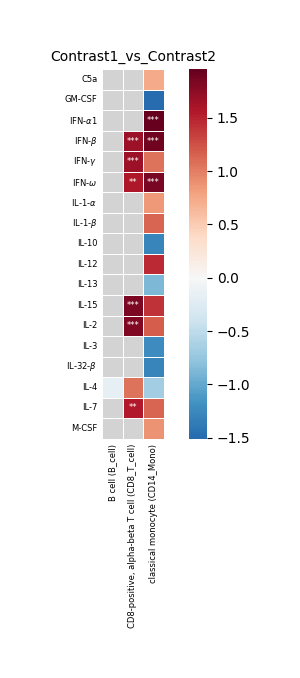

In [12]:
#### Create heatmap to visualize up-/down regulation of cytokines in all queried cell types for one contrast comparison.

robust_results_dict = hc.get_robust_significant_results(
    results=all_enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)


contrast_one = all_enrichment_results.contrast.unique()[0]  # Can be looked up manually
print(f"Contrast that was plotted in this example: {contrast_one}")

hc.plot_significant_results(
    results_pivot=robust_results_dict[contrast_one][0],
    df_annot=robust_results_dict[contrast_one][1],
    fontsize=6,
    save_fig=False,
    fig_path="",
)

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/cytokine_info.xlsx


/home/icb/jenni.liu/miniconda3/envs/cytokine_test/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/jenni.liu/miniconda3/envs/cytokine_test/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/jenni.liu/miniconda3/envs/cytokine_test/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/jenni.liu/miniconda3/envs/cytokine_test/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/jenni.liu/miniconda3/envs/cytokine_test/lib/python3.12/site-packages/scanpy/tools/_rank_genes_grou

/home/icb/jenni.liu/miniconda3/envs/cytokine_test/lib/python3.12/site-packages/hucira/pl/plot_communication.py:210: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


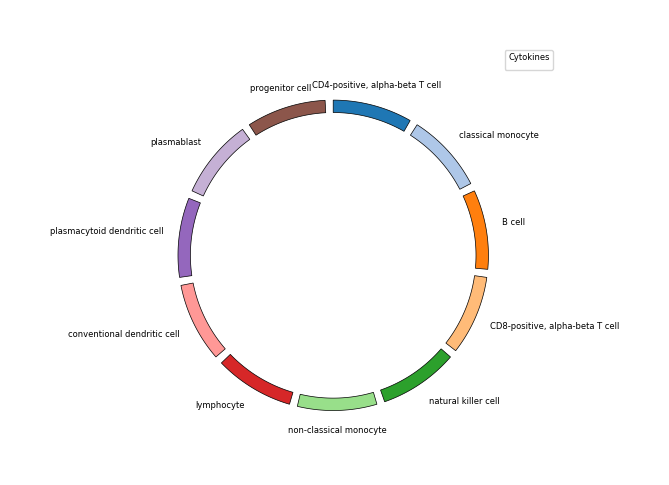

In [13]:
#### Cell-cell communication

cytokine_info = hc.load_cytokine_info()
expression_threshold = 0.1 / 10_000  # = 100 TPM
expression_threshold = np.log2((expression_threshold) + 1)

# Compute cytokine senders and receivers per cell type.
df_senders, df_receivers = hc.get_all_senders_and_receivers(
    adata=adata,
    cytokine_info=cytokine_info,
    cytokine_list=robust_results_dict[contrast_one][2].cytokine.unique(),
    celltype_colname=your_celltype_colname,
    sender_pvalue_threshold=0.1,
    receiver_mean_X_threshold=0,
)

# Plots cell-cell communication
legend_handles, legend_labels = hc.plot_communication(
    df_src=df_senders,
    df_tgt=df_receivers,
    frac_expressing_cells_sender=0,
    frac_expressing_cells_receiver=0,
    mean_cytokine_gene_expression_sender=expression_threshold,
    mean_cytokine_gene_expression_receiver=expression_threshold,
    df_enrichment=robust_results_dict[contrast_one][2],
    all_celltypes=np.array(adata.obs[your_celltype_colname].unique()),
    show_legend=True,
    figsize=(6, 7),
    lw=0.5,
    fontsize=6,
    bbox_to_anchor=(1.1, 1.1),
    loc="center",
)

In [14]:
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

Time: 16 min 13 sec


In [ ]:
## --END-- ##